<a href="https://colab.research.google.com/github/ZaietsMykytaFIT/DTEU-Machine-Learning-2025-Zaiets/blob/main/IM_Lab12_Zaiets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Трансферне навчання

In [17]:
!pip install tensorflow

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 3 = only errors

In [19]:
import kagglehub

path = kagglehub.dataset_download("moazeldsokyx/dogs-vs-cats")

print("Path to dataset files:", path)

100%|██████████| 817M/817M [00:07<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/moazeldsokyx/dogs-vs-cats/versions/1


In [20]:
train_dir = '/kaggle/input/dogs-vs-cats/dataset/train'
val_dir = '/kaggle/input/dogs-vs-cats/dataset/validation'
test_dir = '/kaggle/input/dogs-vs-cats/dataset/test'

In [21]:
class_names = ['Cat', 'Dog']

image_size = (224, 224) # VGG16 default input size for ImageDataGenerator
BATCH_SIZE = 32

# Генератор для тренування з аугментацією + нормалізацією для VGG16

train_datagen = ImageDataGenerator(

    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Генератор для валідації і тесту — тільки нормалізація

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Генератор для тренувального набору

train_generator = train_datagen.flow_from_directory(

    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Генератор для валідаційного набору

val_generator = val_test_datagen.flow_from_directory(

    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Генератор для тестового набору

test_generator = val_test_datagen.flow_from_directory(

    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12461 images belonging to 2 classes.


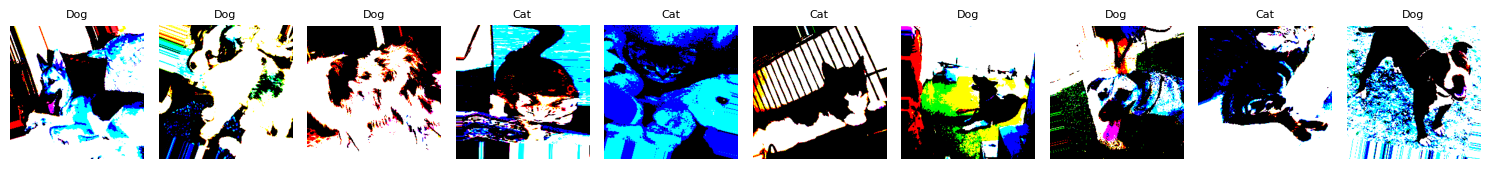

In [22]:
# Отримуємо новий набір зображень
images, labels = next(train_generator)

# Випадкові індекси для 10 зображень
indices = np.random.choice(len(images), size=10, replace=False)

# Візуалізація
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[idx])
    plt.axis('off')
    plt.title(class_names[int(labels[idx])], fontsize=8)
plt.tight_layout()
plt.show()

In [24]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=image_size + (3,)
)

for layer in base_model.layers:
    layer.trainable = False

# Додаємо власні класифікаційні шари
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Створення повної моделі
model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
# Компіляція моделі
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
# Колбеки
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 382s 591ms/step - accuracy: 0.9269 - loss: 0.8559 - val_accuracy: 0.9790 - val_loss: 0.1160 - learning_rate: 1.0000e-04
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 308s 493ms/step - accuracy: 0.9706 - loss: 0.0993 - val_accuracy: 0.9838 - val_loss: 0.0633 - learning_rate: 1.0000e-04
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 516ms/step - accuracy: 0.9783 - loss: 0.0587 - val_accuracy: 0.9852 - val_loss: 0.0578 - learning_rate: 1.0000e-04
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 383s 518ms/step - accuracy: 0.9803 - loss: 0.0527 - val_accuracy: 0.9816 - val_loss: 0.0681 - learning_rate: 1.0000e-04
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 359s 481ms/step - accuracy: 0.9807 - loss: 0.0542 - val_accuracy: 0.9846 - val_loss: 0.0578 - learning_rate: 1.0000e-04
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 483ms/step - accuracy: 0.9853 - loss: 0.0435 - val_accuracy: 0.9864 - val_loss: 0.0592 - learning_rate: 1.0000e-04
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [31]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {acc:.2%}")

390/390 ━━━━━━━━━━━━━━━━━━━━ 69s 177ms/step - accuracy: 0.9871 - loss: 0.0420
Test accuracy: 98.84%


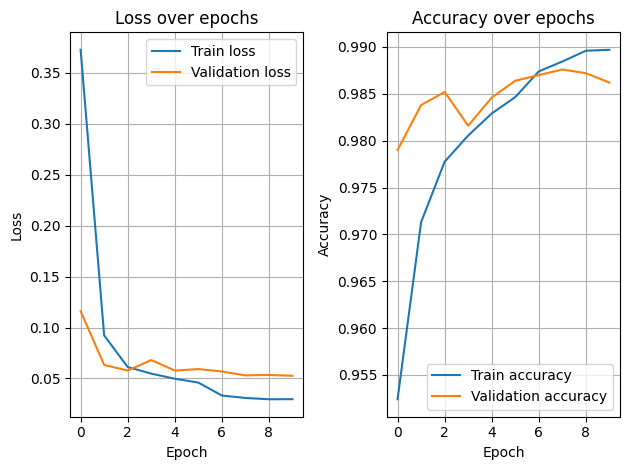

In [32]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Криві точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


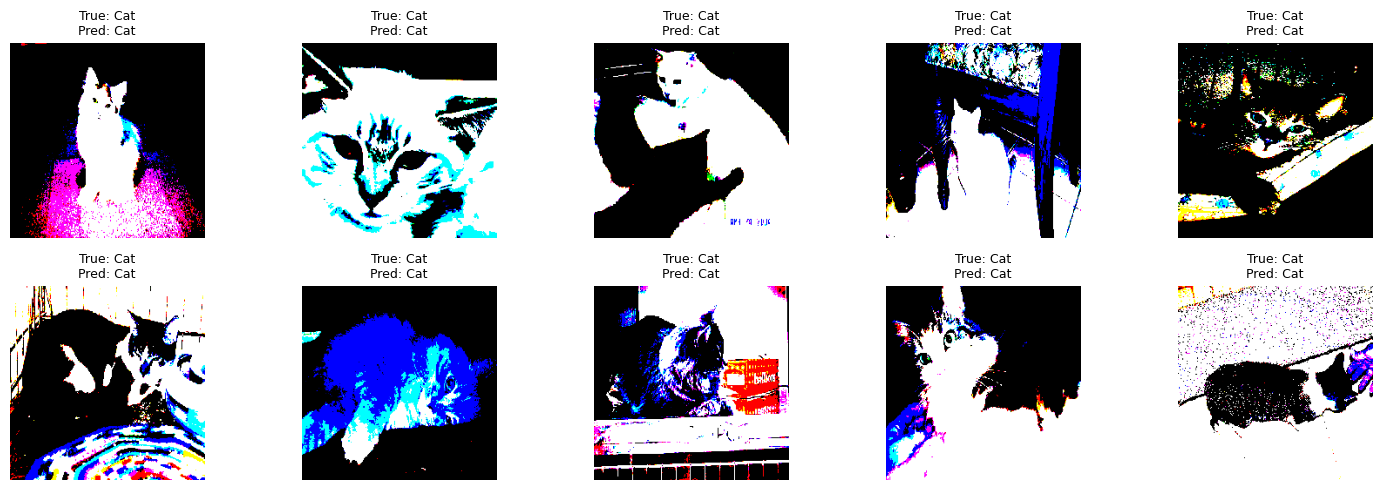

In [30]:
# Отримуємо batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Назви класів
class_names = ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

Висновок: було модифіковано минулу лабораторну роботу 11, де ми змінили модель на претреновану VGG16, і використали відповідну архітектуру. Це збільшило до 98.9%